# Imports

In [1]:
from todels.utils import *
from todels.residual.resnet import Resnet18

import torch
import torch.nn as nn

from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Pytorch version:", torch.__version__)

Device: cuda:0
Pytorch version: 2.0.1+cu118


# Parmaeters

In [3]:
EPOCHS = 50
LEARNING_RATE = 0.1
WEIGHT_DECAY = 1e-5
MOMENTUM = 0.9
IMAGES_SIZE = 32
VAL_SPLIT_SIZE = 0.2
BATCH_SIZE = 1024
SCHEDULAR_GAMMA = 0.99
DATASET_PATH = "./data"

# Dataset

In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Transforms

In [5]:
train_transforms = transforms.Compose([
    transforms.Resize((IMAGES_SIZE, IMAGES_SIZE)),
    transforms.RandomResizedCrop((IMAGES_SIZE,IMAGES_SIZE), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMAGES_SIZE, IMAGES_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

inv_normalize = lambda x : x / 2 + 0.5

## Create Data Loader

In [6]:
train_data = CIFAR10(root=DATASET_PATH, train=True, download=True, transform=train_transforms)
test_data = CIFAR10(root=DATASET_PATH, train=True, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
train_size = int((1-VAL_SPLIT_SIZE) * len(train_data))
val_size = len(train_data) - train_size
train_split, val_split = torch.utils.data.random_split(train_data, [train_size, val_size])

In [8]:
train_loader = torch.utils.data.DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_split, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

## Show

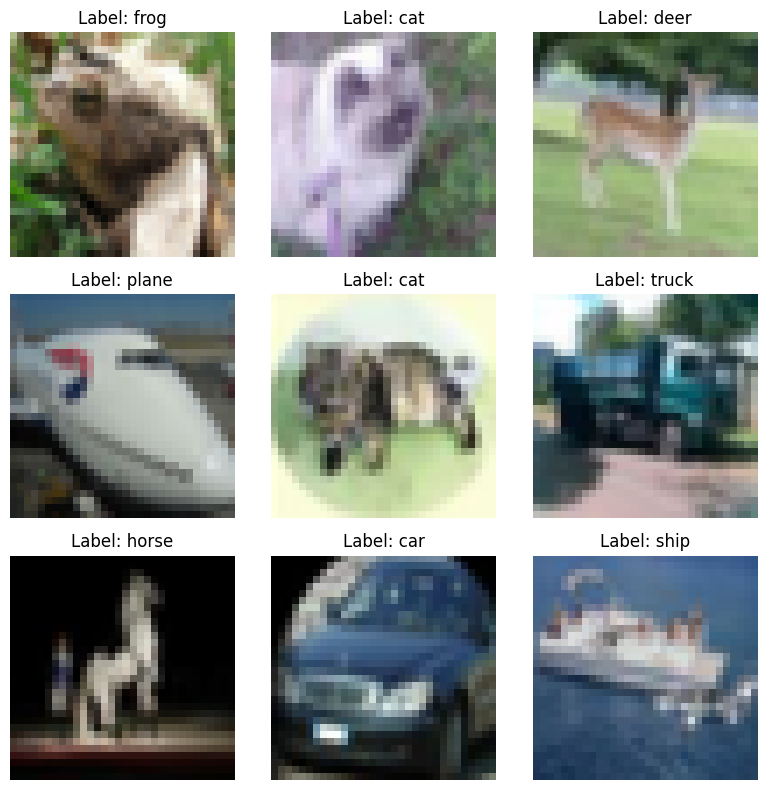

In [9]:
fig = plt.figure(figsize=(8, 8))
for i in range(9):
    rand_idx = int(random() * len(test_data))
    img = test_data[rand_idx][0]
    img = inv_normalize(img)  # unnormalize
    fig.add_subplot(3, 3, i+1)
    plt.title(f"Label: {classes[test_data[rand_idx][1]]}")
    plt.axis('off')
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
plt.tight_layout()
plt.show()

# Functions

## Test Fucntion

In [10]:
@torch.no_grad()
def test(model, test_loader, loss_function=None):
    accuracy = 0
    total = 0
    running_loss = 0
    for (images, labels) in test_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(images)
        if loss_function is not None:
            loss = loss_function(outputs, labels)
            running_loss += loss.item()
        _, predicts = torch.max(outputs.data, 1)
        accuracy += (predicts == labels).sum().item()
        total += labels.size(0)
    res = [(accuracy / total * 100.)]
    if loss_function is not None:
        res += [(running_loss/len(test_loader))]
    return res

## Train functions

In [11]:
def train(model, train_loader, validation_loader, optimizer, loss_function, scheduler, checkpoint, epochs):
    losses = []
    val_losses = []
    accuracies = []
    val_accuracies = []
    best_accuracy = 0
    total_time_train = 0
    early_stopping = EarlyStopping(0.2)
    for epoch in range(epochs):
        running_loss = 0
        accuracy = 0
        total_size = 0
        pbar = ProgressBar(epoch+1, n_samples=len(train_loader), length_bar=40)
        for batch, (images, labels) in enumerate(train_loader):
            # move to target device (gpu)
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            # predict
            model.zero_grad()
            outputs = model(images)
            # cal accuracy
            _, predicts = torch.max(outputs.data, 1)
            accuracy += (predicts == labels).sum().item()
            total_size += labels.size(0)
            # cal loss
            loss = loss_function(outputs, labels)
            loss.backward()
            running_loss += loss.item()
            # optimizer step
            optimizer.step()
            # update progress bar
            addition_output = f"loss={running_loss/(batch+1):>.4f} - accuracy = {accuracy/(total_size):.4%}"
            pbar.next(batch=batch, addition_output=addition_output)

        total_time_train += pbar.take_time
        # append to history
        accuracies.append(accuracy / total_size * 100.)
        losses.append(running_loss / len(train_loader))

        # scheduler
        scheduler.step()

        # test validation data
        val_accuracy, val_loss = test(model, validation_loader, loss_function)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # early stop
        if early_stopping.check(val_loss):
            addition_output = f"loss = {losses[-1]:>.4f} - accuracy = {accuracies[-1]:>.4f}% - val_loss = {val_losses[-1]:>.4f} - val_accuracy: {val_accuracies[-1]:>.4f}%"
            pbar.next(batch=len(train_loader), addition_output=addition_output)
            print("-----------\n Early stop!")
            return {"loss": losses, "val_loss": val_losses, "accuracy": accuracies, "val_accuracy": val_accuracies}

        checkpoint(val_loss)

        # step progress_bar
        addition_output = f"loss = {losses[-1]:>.4f} - accuracy = {accuracies[-1]:>.4f}% - val_loss = {val_losses[-1]:>.4f} - val_accuracy: {val_accuracies[-1]:>.4f}%"
        pbar.next(batch=len(train_loader), addition_output=addition_output)

    return {"loss": losses, "val_loss": val_losses, "accuracy": accuracies, "val_accuracy": val_accuracies}

## Show Predicts Samples

In [12]:
@torch.no_grad()
def show_predicts(model, test_data, n_test=5):
    fig, ax = plt.subplots(2, n_test, figsize=(12, 4))
    model.eval()
    for i in range(n_test):
        rand_index = int(random() * len(test_data))
        image = test_data[rand_index][0]
        img = inv_normalize(image)  # unnormalize
        predicts = model(image.unsqueeze(0).to(device))
        ax[0, i].set_title(f"actual = {classes[int(test_data[rand_index][1])]}")
        ax[0, i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
        ax[0, i].axis(False)
        predicts = nn.functional.softmax(predicts, dim=-1)
        hbars = ax[1, i].barh(classes, predicts.cpu().numpy().flatten() * 100., align='center')
        ax[1, i].set_xlim([0, 100])
        fig.tight_layout()
    plt.show()

## Plot Metrics Function

In [13]:
def plot_metrics(history):
    fig, axes = plt.subplots(2, 1)
    axes[0].set_title("Loss")
    axes[0].plot(history["loss"], label="loss")
    axes[0].plot(history["val_loss"], label="val_loss")
    axes[0].legend()

    axes[1].set_title("Accuracy")
    axes[1].plot(history["accuracy"], label="accuracy")
    axes[1].plot(history["val_accuracy"], label="val_accuracy")
    axes[1].legend()

    plt.tight_layout(pad=2)
    plt.xlabel("epochs")
    plt.show()

# Create Model & Train

## Init Model & Optimizer

In [14]:
resnet18 = Resnet18(10, is_light=True, device=device)
resnet18.fc = nn.Sequential(
    nn.Dropout(0.25),
    nn.Linear(512, 10, device=device),
)
summary(resnet18, (3,IMAGES_SIZE,IMAGES_SIZE))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         ConvBlock-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,928
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
         ConvBlock-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,928
      BatchNorm2d-10           [-1, 64, 32, 32]             128
        ConvBlock-11           [-1, 64, 32, 32]               0
         Identity-12           [-1, 64, 32, 32]               0
   ResnetShortcut-13           [-1, 64, 32, 32]               0
             ReLU-14           [-1, 64,

In [15]:
torch.cuda.empty_cache()
optimizer = torch.optim.SGD(resnet18.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(EPOCHS*0.75), EPOCHS], gamma=SCHEDULAR_GAMMA)
loss_fn = nn.CrossEntropyLoss().to(device)
checkpoint = Checkpoint(resnet18, "Resnet18-CIFAR10.ckpt")

## Train Model

In [16]:
history_resnet = train(resnet18, train_loader, val_loader, optimizer, loss_fn, scheduler, checkpoint, EPOCHS)
model = checkpoint.load()  # load best model

 epochs 1: [=======================================>] 100%  time:67.915s - loss = 1.7853 - accuracy = 34.5775% - val_loss = 1.8744 - val_accuracy: 34.9300%
 epochs 2: [=======================================>] 100%  time:61.223s - loss = 1.4010 - accuracy = 48.7650% - val_loss = 1.3417 - val_accuracy: 50.7500%
 epochs 3: [=======================================>] 100%  time:61.990s - loss = 1.1449 - accuracy = 58.5525% - val_loss = 1.0781 - val_accuracy: 61.7500%
 epochs 4: [=======================================>] 100%  time:59.784s - loss = 0.9379 - accuracy = 66.5700% - val_loss = 0.9351 - val_accuracy: 66.6200%
 epochs 5: [=======================================>] 100%  time:59.682s - loss = 0.8222 - accuracy = 71.0275% - val_loss = 0.8619 - val_accuracy: 70.4300%
 epochs 6: [=======================================>] 100%  time:60.218s - loss = 0.7558 - accuracy = 73.5400% - val_loss = 0.8162 - val_accuracy: 72.1100%
 epochs 7: [=======================================>] 100%  time

## Plot Metrics

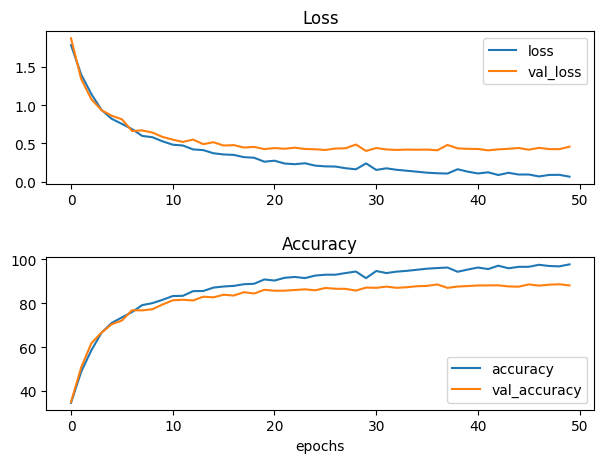

In [17]:
plot_metrics(history_resnet)

## Test

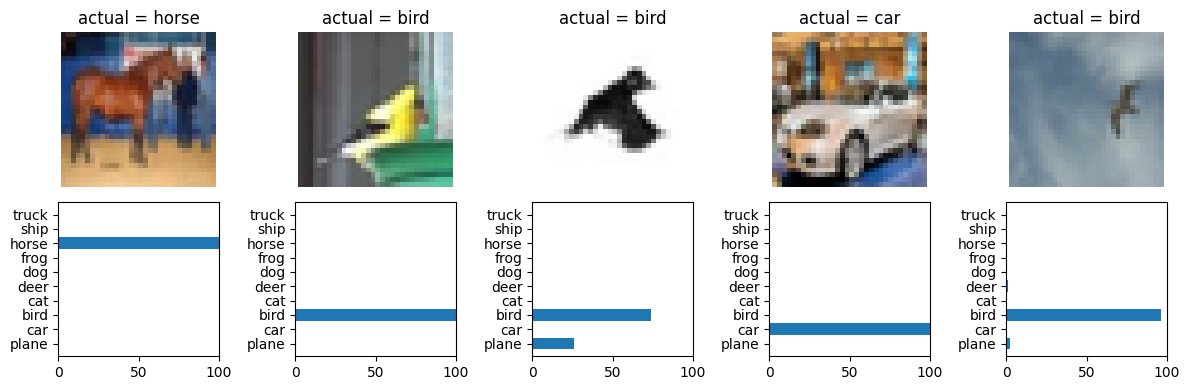

In [18]:
show_predicts(model, test_data)

# Result

In [19]:
accuracy, loss = test(model, test_loader, loss_fn)
print(f"accuracy = {accuracy:>.2f}%")
print(f"loss = {loss:>.2f}")

accuracy = 96.60%
loss = 0.12
